# MNIST classification example with TensorFlow

## Needed librairies

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
tf.__version__

'1.12.0'

In [3]:
tf.enable_eager_execution()

In [4]:
tf.executing_eagerly() 

True

## Import the Data

In [5]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [6]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [7]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [8]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [9]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [10]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [11]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [12]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [13]:
x_train.shape

(60000, 784)

In [14]:
x_test.shape

(10000, 784)

## Reshape the labels

In [15]:
y_train.shape

(60000,)

In [16]:
y_test.shape

(10000,)

In [17]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [18]:
num_classes = len(np.unique(y_train))
num_classes

10

In [19]:
y_train_ = np.zeros((len(y_train), num_classes))
y_test_ = np.zeros((len(y_test), num_classes))

In [20]:
y_train_[np.arange(len(y_train)), y_train] = 1
y_test_[np.arange(len(y_test)), y_test] = 1

In [21]:
y_train=y_train_
y_test=y_test_

In [22]:
y_train.shape

(60000, 10)

In [23]:
y_test.shape

(10000, 10)

In [24]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

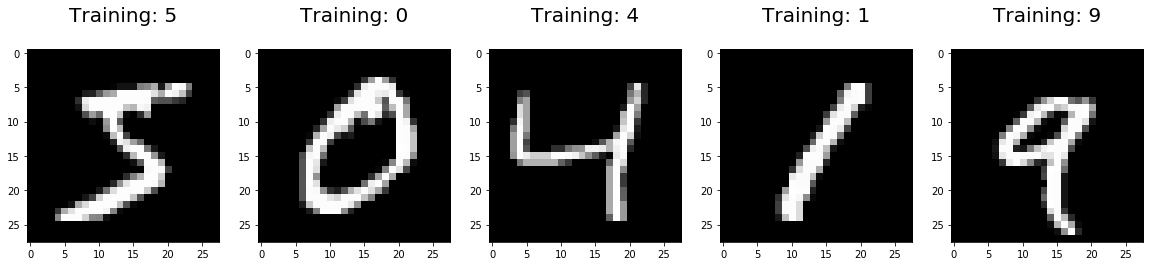

In [25]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [26]:
# print info every n_print
n_print = 1

# hidden layer 1
n1=300

learning_r=0.01

## Defined our model

In [27]:
# x [60000, 784]
# y [60000, 10]

# 1 layer n1 with 200 neurones
# n1 = 300

#  . . . . . .    input data (ffattened pixels)      x [batch    ,   dim_input]
#   \x/\x/x/      -- fully connected layer (relu)    W1[dim_input,          n1]      B1[n1         ]
#    . . .                                           Y1[batch    ,          n1]
#     \x/         -- fully connected layer (softmax) W2[n1       , num_classes]      B2[num_classes]
#      .                                             Y2[batch    , num_classes]

# reset graph before starting
tf.reset_default_graph()

# tensor (placeholder) for the learning rate: learning_rate -> not needed with Eager execution

# tensor (placeholder) for the momentum: momentum -> not needed with Eager execution

# tensor (placeholder) for the input data [60000, 784]: x -> not needed with Eager execution

# tensor (placeholder) for the output data [60000, 10]: y -> not needed with Eager execution

# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([dim_input, n1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n1]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([n1, num_classes], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([num_classes]), name='b2')

# now let's define the cost function which we are going to train the model on
# cross entropy defined manually -> need to be a function in Eager mode
# -sum(y * log(y_) + (1-y) * log(1-y_))
# need to be a function -> Eager execution
def cost(x,y): 
    
    # calculate the output of the hidden layer
    Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    # last layer
    Ylogits= tf.matmul(Y1, W2) + b2

    # output layer
    y_ = tf.nn.softmax(Ylogits)
    
    y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # if value are below 1e-10 return 1e-10 same of 0.9999999
    cross_entropy = tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1)
    cost = -tf.reduce_mean(cross_entropy)
    
    return cost

# define an accuracy assessment operation
# need to be a function -> Eager execution
def acc(x, y):
    # calculate the output of the hidden layer
    Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    # last layer
    Ylogits= tf.matmul(Y1, W2) + b2

    # output layer
    y_ = tf.nn.softmax(Ylogits)
    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy.numpy() 

In [28]:
cost(x_train,y_train)

<tf.Tensor: id=82, shape=(), dtype=float32, numpy=4.33332>

In [29]:
cost(x_train,y_train).numpy()

4.33332

In [30]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    cost_history_train = np.empty(shape=[0], dtype = float)
    cost_history_test = np.empty(shape=[0], dtype = float)
    
    # add an optimiser
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_r)

    # to add for Eager optimisa
    grad=tfe.implicit_gradients(cost)

    for epoch in range(training_epochs+1):
        
        optimiser.apply_gradients(grad(train_obs, train_labels))
        
        cost_train = cost(train_obs, train_labels).numpy()
        cost_history_train = np.append(cost_history_train, cost_train)
            
        cost_test = cost(test_obs, test_labels).numpy()
        cost_history_test = np.append(cost_history_test, cost_test)
        
        if (epoch % n_print == 0) & debug:
            print("Reached epoch", epoch, "cost J =", str.format('{0:.6f}', cost_train))
        
            acc_train=acc(train_obs, train_labels)
            acc_test=acc(test_obs, test_labels)      

            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
    
    return cost_history_train, cost_history_test

In [31]:
cost_history_train, cost_history_test = run_logistic_model(learning_r = 0.2, 
                                                           training_epochs = 50,
                                                           train_obs = x_train, 
                                                           train_labels = y_train, 
                                                           test_obs = x_test,
                                                           test_labels = y_test, 
                                                           debug = True)

Reached epoch 0 cost J = 5.408175
 accurary on the training set 0.10
 accurary on the testing set 0.11
Reached epoch 1 cost J = 5.580044
 accurary on the training set 0.18
 accurary on the testing set 0.17
Reached epoch 2 cost J = 5.529141
 accurary on the training set 0.12
 accurary on the testing set 0.12
Reached epoch 3 cost J = 5.600915
 accurary on the training set 0.29
 accurary on the testing set 0.29
Reached epoch 4 cost J = 5.278429
 accurary on the training set 0.16
 accurary on the testing set 0.16
Reached epoch 5 cost J = 5.283651
 accurary on the training set 0.28
 accurary on the testing set 0.29
Reached epoch 6 cost J = 4.475627
 accurary on the training set 0.24
 accurary on the testing set 0.24
Reached epoch 7 cost J = 3.790024
 accurary on the training set 0.40
 accurary on the testing set 0.39
Reached epoch 8 cost J = 3.315337
 accurary on the training set 0.50
 accurary on the testing set 0.50
Reached epoch 9 cost J = 3.005593
 accurary on the training set 0.49
 acc

In [32]:
print ("Accuracy on training data:", acc(x_train, y_train))
print ("Accuracy on testing data:",  acc(x_test, y_test))

Accuracy on training data: 0.86581665
Accuracy on testing data: 0.871


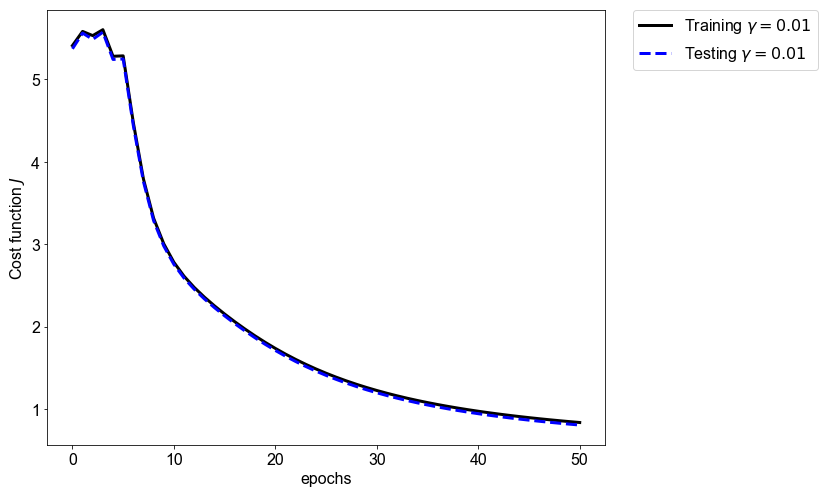

In [33]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history_train, ls='-', color = 'black', lw = 3, label = r'Training $\gamma = 0.01$')
ax.plot(cost_history_test, ls='--', color = 'blue', lw = 3, label = r'Testing $\gamma = 0.01$')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);